In [28]:
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import brown
import matplotlib.pyplot as plt
from nltk.tag.hmm import HiddenMarkovModelTrainer
import networkx as nx
import random

# Tagging

In [29]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /Users/bilal/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/bilal/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [30]:
tagged_sentences = brown.tagged_sents(tagset='universal')
print(f"Total sentences: {len(tagged_sentences)}")

tagged_sentences = [[(word.lower(), tag) for (word, tag) in sent]
                    for sent in tagged_sentences]

Total sentences: 57340


In [31]:
random.seed(42)
random.shuffle(tagged_sentences)
split_idx = int(0.9 * len(tagged_sentences))

train_sents = tagged_sentences[:split_idx]
test_sents = tagged_sentences[split_idx:]

print(f"Training sentences: {len(train_sents)}, Test sentences: {len(test_sents)}")

Training sentences: 51606, Test sentences: 5734


In [32]:
vocab = set(word for sent in train_sents for (word, tag) in sent)
tags = set(tag for sent in train_sents for (word, tag) in sent)

print(f"Vocab size: {len(vocab)}, Number of tags: {len(tags)}")
print(f"Tags: {tags}")

Vocab size: 47614, Number of tags: 12
Tags: {'ADJ', 'NOUN', 'VERB', 'CONJ', 'PRON', 'NUM', 'X', '.', 'ADP', 'ADV', 'PRT', 'DET'}


In [35]:
trainer = HiddenMarkovModelTrainer()
hmm_tagger = trainer.train_supervised(train_sents)

In [36]:
accuracy = hmm_tagger.evaluate(test_sents)
print(f"HMM Tagger Accuracy on Test Set: {accuracy:.4f}")

/var/folders/wz/_772lgm922vg_g6rzv3nzmy00000gn/T/ipykernel_56456/516451828.py:1: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = hmm_tagger.evaluate(test_sents)
/Users/bilal/Documents/5100 - Prob Modelling and Stats/case study/hmm-pos-tagging-demo/venv/lib/python3.13/site-packages/nltk/tag/hmm.py:335: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
/Users/bilal/Documents/5100 - Prob Modelling and Stats/case study/hmm-pos-tagging-demo/venv/lib/python3.13/site-packages/nltk/tag/hmm.py:363: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


HMM Tagger Accuracy on Test Set: 0.7725


In [37]:
test_sentence = ["the", "cat", "sat", "on", "the", "mat"]
tagged = hmm_tagger.tag(test_sentence)
print("Tagged sentence:")
print(tagged)

Tagged sentence:
[('the', 'DET'), ('cat', 'NOUN'), ('sat', 'VERB'), ('on', 'ADP'), ('the', 'DET'), ('mat', 'NOUN')]


# Graphing

In [38]:
def tag_sentence(sentence):
    return hmm_tagger.tag(sentence)

In [39]:
def top_n_tags(word, n=3, viterbi_tag=None):
    """
    Returns top n tags for a word for visualization.
    viterbi_tag = tag selected by Viterbi
    """
    states = list(hmm_tagger._states)
    tags = []
    
    if viterbi_tag:
        tags.append(viterbi_tag)  # always include Viterbi tag
    
    # Fill remaining slots with other tags
    for tag in states:
        if tag != viterbi_tag and len(tags) < n:
            tags.append(tag)
    
    return tags

In [40]:
def build_columnar_viterbi_graph(sentence, top_n=3):
    """
    Build a graph with:
    - n columns = words
    - top_n tags per word as nodes
    - edges connecting consecutive columns
    - Viterbi path highlighted
    """
    G = nx.DiGraph()
    
    # Compute Viterbi path
    tagged = hmm_tagger.tag(sentence)
    viterbi_tags = [tag for word, tag in tagged]
    
    node_positions = {}
    nodes_per_column = []
    
    # Create nodes for top-N tags per word
    for i, word in enumerate(sentence):
        v_tag = viterbi_tags[i]
        tags = top_n_tags(word, top_n, viterbi_tag=v_tag)   
        nodes = []
        for j, tag in enumerate(tags):
            node_id = f"{i}_{tag}"
            G.add_node(node_id, label=f"{tag}\n'{word}'")
            # x = column index, y = vertical position (spread top-N)
            node_positions[node_id] = (i, top_n - j)
            nodes.append(node_id)
        nodes_per_column.append(nodes)
    
    # Connect nodes between consecutive columns
    for col in range(len(nodes_per_column)-1):
        for src in nodes_per_column[col]:
            for tgt in nodes_per_column[col+1]:
                # Highlight edge if both are Viterbi path
                src_tag = src.split("_")[1]
                tgt_tag = tgt.split("_")[1]
                if src_tag == viterbi_tags[col] and tgt_tag == viterbi_tags[col+1]:
                    G.add_edge(src, tgt, color='green', weight=2)
                else:
                    G.add_edge(src, tgt, color='gray', weight=0.5)
    
    return G, node_positions, tagged

In [41]:
def plot_columnar_viterbi(G, node_positions):
    colors = [G[u][v]['color'] for u,v in G.edges()]
    weights = [G[u][v]['weight'] for u,v in G.edges()]
    
    plt.figure(figsize=(14,6))
    nx.draw(
        G, pos=node_positions, 
        with_labels=True,
        labels=nx.get_node_attributes(G, 'label'),
        node_size=2000, node_color="#f0f0f0",
        font_size=10, font_weight='bold',
        edge_color=colors, width=weights
    )
    plt.show()

['the', 'cat', 'sat', 'on', 'the', 'mat']

Tagged Sentence:
[('the', 'DET'), ('cat', 'NOUN'), ('sat', 'VERB'), ('on', 'ADP'), ('the', 'DET'), ('mat', 'NOUN')]

Viterbi Tagged Sentence:
[('the', 'DET'), ('cat', 'NOUN'), ('sat', 'VERB'), ('on', 'ADP'), ('the', 'DET'), ('mat', 'NOUN')]


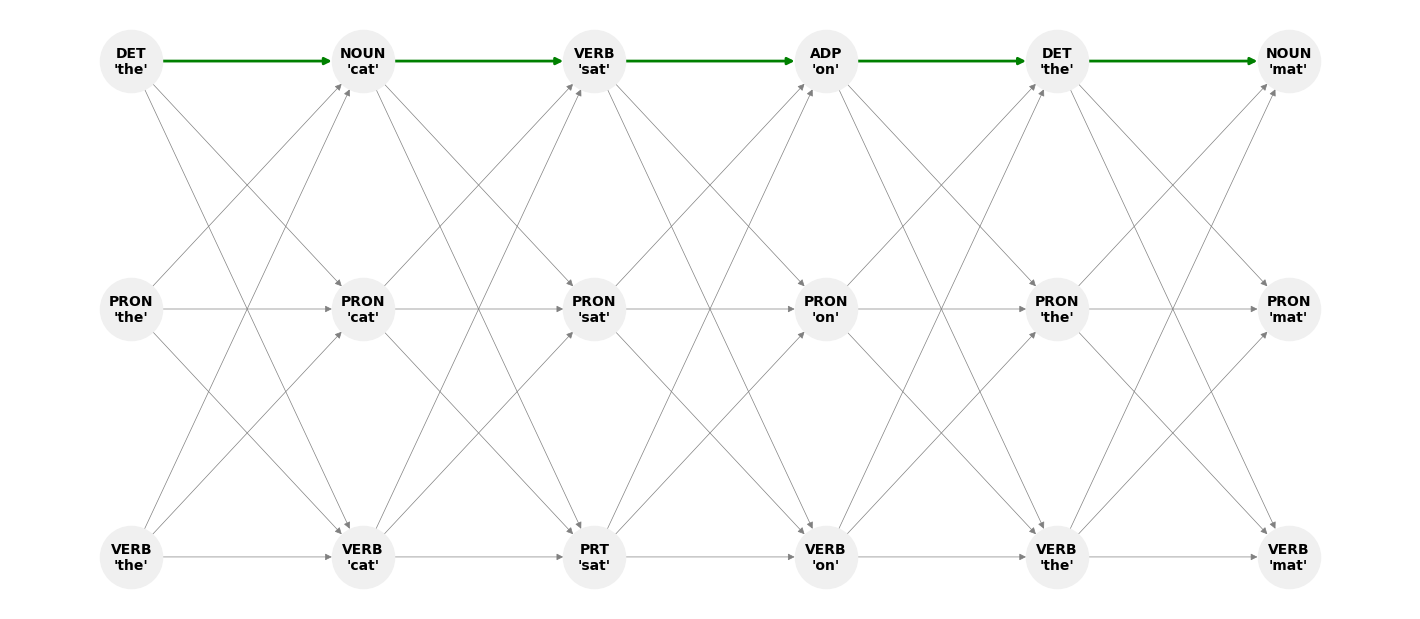

In [42]:
sentence = "the cat sat on the mat"
words = sentence.split()
print(words)
tagged = tag_sentence(words)
print("\nTagged Sentence:")
print(tagged)

G, node_positions, tagged = build_columnar_viterbi_graph(words, top_n=3)
print("\nViterbi Tagged Sentence:")
print(tagged)
plot_columnar_viterbi(G, node_positions)